<a href="https://colab.research.google.com/github/Skulduggery64/TensorFlow-DeepLearning_2020/blob/master/NN_BPC6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experimental Skript for a Neural Network to predict BPC6 DNA bindung


Mount Google drive (nnproject2020@gmail.com)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import all needed liberies, some may are not used. Jused added a lot of them an never deleted not needed ones ;) 


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import normalize
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.utils import Sequence
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
import pickle
from numpy import loadtxt
import math
import random
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython.display import clear_output


Load Data:

*   Imput: numpy-array of one-hot-end encoded genome sequence (shape: chromosome length, 4) 

  example: ACGTN --> [[0,0,0,1][0,0,1,0][0,1,0,0][1,0,0,0][0,0,0,0]]

*   lable Number(integer) proportional to the proteins bound on this position in a ChiP-seq-experiment. 
  
  One value per position (shape:  chromosome length, 1)

Data for each chromosome is loaded individualy and concatenated together

In [ ]:
train_data= np.load("/content/drive/My Drive/BPC6Chip/Genome/Chr1Hot.npy")
train_lable=  np.load("/content/drive/My Drive/BPC6Chip/Chip/Chr1/chip-BPC-1-1.npy")
print(train_data.shape)
print(train_lable.shape)

train_data1= np.load("/content/drive/My Drive/BPC6Chip/Genome/Chr2Hot.npy")
train_lable1 = np.load("/content/drive/My Drive/BPC6Chip/Chip/Chr2/chip-BPC-1-1.npy")

train_lable1 = np.expand_dims(train_lable1,1)
print(train_data1.shape)
print(train_lable1.shape)
train_data=np.concatenate((train_data,train_data1),0)
train_lable=np.concatenate((train_lable,train_lable1),0)

train_data1= np.load("/content/drive/My Drive/BPC6Chip/Genome/Chr3Hot.npy")
train_lable1 = np.load("/content/drive/My Drive/BPC6Chip/Chip/Chr3/chip-BPC-1-1.npy")

train_lable1 = np.expand_dims(train_lable1,1)
print(train_data1.shape)
print(train_lable1.shape)
train_data=np.concatenate((train_data,train_data1),0)
train_lable=np.concatenate((train_lable,train_lable1),0)


train_data1= np.load("/content/drive/My Drive/BPC6Chip/Genome/Chr4Hot.npy")
train_lable1 = np.load("/content/drive/My Drive/BPC6Chip/Chip/Chr4/chip-BPC-1-1.npy")

train_lable1 = np.expand_dims(train_lable1,1)
print(train_data1.shape)
print(train_lable1.shape)
train_data=np.concatenate((train_data,train_data1),0)
train_lable=np.concatenate((train_lable,train_lable1),0)


train_data1= np.load("/content/drive/My Drive/BPC6Chip/Genome/Chr5Hot.npy")
train_lable1 = np.load("/content/drive/My Drive/BPC6Chip/Chip/Chr5/chip-BPC-1-1.npy")

train_lable1 = np.expand_dims(train_lable1,1)
print(train_data1.shape)
print(train_lable1.shape)
train_data=np.concatenate((train_data,train_data1),0)
train_lable=np.concatenate((train_lable,train_lable1),0)

print(train_data.shape)
print(train_lable.shape)
train_data1=()
train_lable1 = ()
Max=max(train_lable)
train_lable=train_lable/Max


(30432567, 4)
(30432567, 1)
(19705359, 4)
(19705359, 1)
(23470805, 4)
(23470805, 1)
(18585056, 4)
(18585056, 1)
(26992728, 4)
(26992728, 1)
(119186515, 4)
(119186515, 1)



Set  hyperparameters:

sampelSize  =  how  many  data  will  be  used  (maximal)  

seqLength  =  How  long  is  the  Input  sequence

stepsize  =  how  much  space  left  between  pecked  samples

testSetlegth  =  number  of  data  in  the  test/validation  set

labelWindow  =  the  range  of  output  data  (labels)  that  should  be  predicted  (centred  to  the  input  data)

bins  =  number  of  equal  spaced  windows  to  normalize  the  data  (discribed  later)

batch_size=Batch  size  used  for  batch  gradient  decent

Testfaktor  =  ratio  of  the  data  separated  as  validation/test  set.  Data  a  separated  as  one  chunk  because  close  data  are  highly  equal.  By  separating  them  as  one  chunk  similar  data  in  train  and  test  set  are  avoided.



In [ ]:
sampleSize = 250000
Testfaktor=0.2
seqLength= 100
testSetLength= sampleSize*Testfaktor
labelWindow=1
bins=3
batch_size=128



separating test data from train data and print where the test set starts

In [ ]:
rand = np.random.randint(0,len(train_lable)-int(len(train_lable)*Testfaktor),size=1)
rand=int(rand[0])
print(rand,rand+int(len(train_lable)*Testfaktor))
test_data= train_data[rand:rand+int(len(train_lable)*Testfaktor),:]
test_label = train_lable[rand:rand+int(len(train_lable)*Testfaktor),:]

train_data=np.delete(train_data,np.s_[rand:rand+int(len(train_lable)*Testfaktor)],0)
train_lable=np.delete(train_lable,np.s_[rand:rand+int(len(train_lable)*Testfaktor)],0)

print(train_data.shape)
print(train_lable.shape)
print(test_data.shape)
print(test_label.shape)

Chr1test=rand
Chr2test=(rand-30432567)
Chr3test=(rand-30432567-19705359)
Chr4test=(rand-30432567-19705359-23470805)
Chr5test=(rand-30432567-19705359-23470805-18585056)

if Chr2test < 0:
  print("Test set begins at Chromosome 1")
  print(Chr1test)
if Chr2test > 0 and Chr3test <0:
  print("Test set begins at Chromosome 2")
  print(Chr2test)
if Chr3test > 0 and Chr4test < 0:
  print("Test set begins at Chromosome 3")
  print(Chr3test)
if Chr4test > 0 and Chr5test<0:
  print("Test set begins at Chromosome 4")
  print(Chr4test)
if Chr5test > 0 :
  print("Test set begins at Chromosome 5")
  print(Chr5test)


50544201 74381504
(95349212, 4)
(95349212, 1)
(23837303, 4)
(23837303, 1)
Test set begins at Chromosome 3
406275


Function to normalize the data based on equal spaced windows. 

the plt.hist function creates a Histogram of the label data with a number of bins defined above 

pick equal number of data per bin. If the number of data in one bin is smaller than sampleSize/bins all data from that bin are picked.

In the end the reverse complement sequences are attached and the labels are doubled to match this. 

The loaded data are erased to free ram.



(38548, 1)
(38548, 100, 4)
(183968, 1)
(183968, 100, 4)


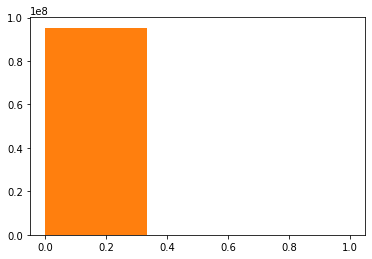

In [ ]:
hist_border=plt.hist(train_lable,bins=bins)[1]
hist_size=plt.hist(train_lable,bins=bins)[0]
index_label=np.array(range(0,len(test_label)))
index_label=index_label.reshape((len(index_label),1))
test_T=np.zeros((1,seqLength,4))
test_L=np.zeros((1,1))
for i in range(0,len(hist_border)-1):
  sample_i=index_label[np.where(np.logical_and(test_label>=hist_border[i], test_label<=hist_border[i+1]))]
  test_T1=np.zeros((min(int(testSetLength/bins),len(sample_i)),seqLength,4))
  test_L1=np.zeros((min(int(testSetLength/bins),len(sample_i)),1))
  rand=np.random.choice(sample_i,size=min(int(testSetLength/bins),len(sample_i)),replace=False)
  rand=np.delete(rand,np.where(rand>=(len(test_label[:,0])-seqLength)))
  rand=np.delete(rand,np.where(rand<seqLength))
  x=0
  for j in rand:
    test_T1[x]= test_data[int(j-seqLength/2):int(j+seqLength/2)]
    test_L1[x] = np.mean(test_label[int(j-labelWindow/2):int(j+labelWindow/2)])
    x = x+1
  test_T=np.concatenate((test_T,test_T1),0)
  test_L=np.concatenate((test_L,test_L1),0)

test_T=np.concatenate((test_T,np.flip(np.flip(test_T,axis=1),axis=2)),0)
test_L=np.concatenate((test_L,test_L),0)



print(test_L.shape)
print(test_T.shape)
test_label=()
test_data=()

index_label=np.array(range(0,len(train_lable)))
index_label=index_label.reshape((len(index_label),1))
train=np.zeros((1,seqLength,4))
lable=np.zeros((1,1))
for i in range(0,len(hist_border)-1):
  sample_i=index_label[np.where(np.logical_and(train_lable>=hist_border[i], train_lable<=hist_border[i+1]))]
  train1=np.zeros((min(int(sampleSize/bins),len(sample_i)),seqLength,4))
  lable1=np.zeros((min(int(sampleSize/bins),len(sample_i)),1))
  rand=np.random.choice(sample_i,size=min(int(sampleSize/bins),len(sample_i)),replace=False)
  rand=np.delete(rand,np.where(rand>=(len(train_lable[:,0])-seqLength)))
  x=0
  for j in rand:
    train1[x]= train_data[int(j-seqLength/2):int(j+seqLength/2)]
    lable1[x] = np.mean(train_lable[int(j-labelWindow/2):int(j+labelWindow/2)])
    x = x+1
  train=np.concatenate((train,train1),0)
  lable=np.concatenate((lable,lable1),0)

train=np.concatenate((train,np.flip(np.flip(train,axis=1),axis=2)),0)
lable=np.concatenate((lable,lable),0)

print(lable.shape)
print(train.shape)
train_data=()
train_lable=()

(38548, 1)

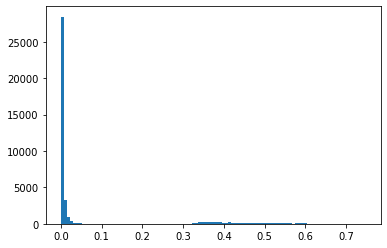

In [ ]:
plt.hist(test_L,bins=100)
plt.show
test_L.shape

(183968, 1)

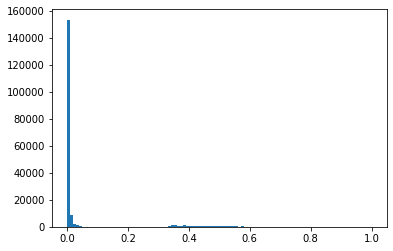

In [ ]:
plt.hist(lable,bins=100)
plt.show
lable.shape

Some factions:

Logcosh = loss function 

tensor to array needed to calculate Pearson correlation in tf_person correlation. Can be used as matrices to show model performance but do not work in TF 2.0

look_at_adta = function to plot predicted and true labels and calculate the correlation to show model performance

quan = loss function

swish = new activation function


In [ ]:

def tf_pearson(y_true, y_pred):
    return tf.contrib.metrics.streaming_pearson_correlation(y_pred, y_true)[1]
def logcosh(true, pred):
    loss = keras.logcosh(abs(pred - true))
    return k.sum(loss)*1000
def tensor_to_array(tensor1):
    return tensor1.numpy()
def look_at_data(test_train,test_label):
  pre = list()
  thru = list()
  pre= model.predict(test_train)
  thru=(test_label)
  pre=np.ndarray.tolist(pre)
  thru=np.ndarray.tolist(thru)
  plt.axis(xmin=0,ymin=0,xmax=1,ymax=1)
  plt.plot(pre,thru,".")
  plt.show()
  flatpre=[]
  flatThru=[]
  for elem in pre:
      for item in elem:
          flatpre.append(item)
  for elem in thru:
      for item in elem:
          flatThru.append(item)
  
  print(np.corrcoef(flatpre,flatThru)[0,1])

def quan(true, pred, theta):
    loss = np.where(true >= pred, theta*(np.abs(true-pred)), (1-theta)*(np.abs(true-pred)))
    return np.sum(loss)
    
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({"swish": Activation(swish)})

Using TensorFlow backend.


Plot losses after each epoch while training

In [ ]:
# updatable plot
# a minimal example (sort of)
%matplotlib inline
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):     
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [ ]:
do = 0.6
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((seqLength,4)),
    tf.keras.layers.Conv1D(128,9,padding="same",activation=swish),
    tf.keras.layers.SpatialDropout1D(do),
    tf.keras.layers.Conv1D(128,9,padding="same",activation=swish),
    tf.keras.layers.SpatialDropout1D(do),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(64,9,padding="same",activation=swish),
    tf.keras.layers.SpatialDropout1D(do),
    tf.keras.layers.Conv1D(64,9,padding="same",activation=swish),
    tf.keras.layers.SpatialDropout1D(do),
    tf.keras.layers.MaxPool1D(), 
    tf.keras.layers.Conv1D(64,9,padding="same",activation=swish),
    tf.keras.layers.Flatten(),    
    tf.keras.layers.Dropout(do),      
    tf.keras.layers.Dense(256,activation=swish) ,
    tf.keras.layers.Dropout(do),
    tf.keras.layers.Dense(256,activation=swish) ,
    tf.keras.layers.Dropout(do),
    tf.keras.layers.Dense(128,activation=swish) ,
    tf.keras.layers.Dense(1,activation=swish),
])
history=()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 100, 128)          4736      
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 100, 128)          0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 100, 128)          147584    
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 100, 128)          0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 50, 128)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 50, 64)            73792     
_________________________________________________________________
spatial_dropout1d_16 (Spatia (None, 50, 64)           

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(   loss="MSE")

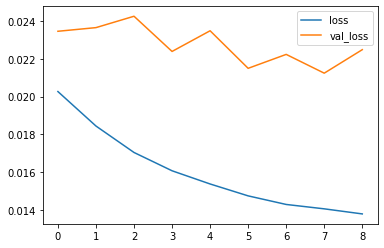

180/180 [==============================] - 24s 134ms/step - loss: 0.0138 - val_loss: 0.0225
Epoch 10/50
131/180 [====================>.........] - ETA: 6s - loss: 0.0137

KeyboardInterrupt: ignored

In [ ]:
history = model.fit(train,lable, epochs=50, validation_data=(test_T,test_L),
                    callbacks=[plot_losses], verbose=1,batch_size=1024 )

Plot some test data (true data Y-axis, predicted data X-axis) and calcualte the correlation

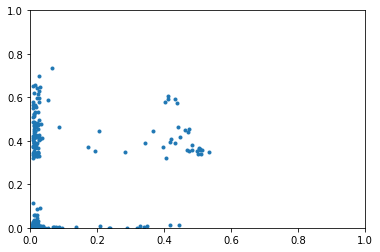

0.39248141410374815


In [ ]:
rand = np.random.randint(0,test_L.shape[0],size=1000)
look_at_data(test_T[rand],test_L[rand])

Plot some train data (true data Y-axis, predicted data X-axis) and calcualte the correlation

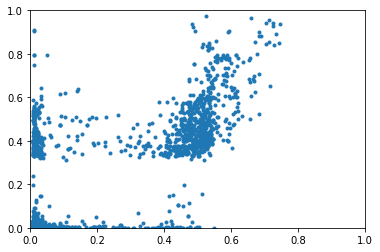

0.8360830232503306


In [ ]:
rand = np.random.randint(0,lable.shape[0],size=10000)
look_at_data(train[rand],lable[rand])

Load the chromosome with the test data on it




In [ ]:
if Chr2test < 0:
  test_data= np.load("/content/drive/My Drive/BPC6Chip/Genome/Chr1Hot.npy")
  test_label=  np.load("/content/drive/My Drive/BPC6Chip/Chip/Chr1/chip-BPC-1-1.npy")
  test_pos=Chr1test
if Chr2test > 0 and Chr3test <0:
  test_data= np.load("/content/drive/My Drive/BPC6Chip/Genome/Chr2Hot.npy")
  test_label=  np.load("/content/drive/My Drive/BPC6Chip/Chip/Chr2/chip-BPC-1-1.npy")
  test_label = np.expand_dims(test_label,1)
  test_pos=Chr2test
if Chr3test > 0 and Chr4test <0:
  test_data= np.load("/content/drive/My Drive/BPC6Chip/Genome/Chr3Hot.npy")
  test_label=  np.load("/content/drive/My Drive/BPC6Chip/Chip/Chr3/chip-BPC-1-1.npy")
  test_label = np.expand_dims(test_label,1)
  test_pos=Chr3test
if Chr4test > 0 and Chr5test < 0:
  test_data= np.load("/content/drive/My Drive/BPC6Chip/Genome/Chr4Hot.npy")
  test_label=  np.load("/content/drive/My Drive/BPC6Chip/Chip/Chr4/chip-BPC-1-1.npy")
  test_label = np.expand_dims(test_label,1)
  test_pos=Chr4test
if Chr5test > 0 :
  test_data= np.load("/content/drive/My Drive/BPC6Chip/Genome/Chr5Hot.npy")
  test_label=  np.load("/content/drive/My Drive/BPC6Chip/Chip/Chr5/chip-BPC-1-1.npy")
  test_label = np.expand_dims(test_label,1)
  test_pos=Chr5test


In [ ]:
def window_stack(a, stepsize=1, width=3):
    return np.hstack( a[i:1+i-width or None:stepsize] for i in range(0,width))
def running_mean(x, N):
  cumsum = np.cumsum(np.insert(x, 0, 0)) 
  return (cumsum[N:] - cumsum[:-N]) / float(N)

plot a rigion from the test set

918275


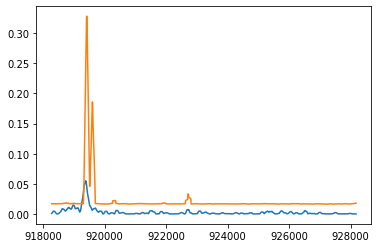

In [ ]:
window=100
testwindow=10000
start=test_pos+512000
print(start)
testW_train=test_data[start:start+testwindow]
testW_label=test_label[start:start+testwindow]

train1=np.zeros((len(testW_label),seqLength,4))
lable1=np.zeros((len(testW_label),1))
x=0
for j in range(int(seqLength/2),int(len(testW_label)-seqLength/2)):
  train1[x]= testW_train[int(j-seqLength/2):int(j+seqLength/2)]
  lable1[x] = np.mean(testW_label[int(j-labelWindow/2):int(j+labelWindow/2)])
  x = x+1
testW_train=train1
testW_label=lable1

testW_label=testW_label/Max
testW_label=running_mean(testW_label,window)
xaxis=range(start,start+testwindow)
xaxis=xaxis[:-window+1]
plt.plot(xaxis,testW_label)
pre= model.predict(testW_train)
pre = running_mean(pre,window)
pre=np.ndarray.tolist(pre)

plt.plot(xaxis,pre)